In [123]:
using Plots; gr()
using Reproduce
using FileIO
using Statistics
using ProgressMeter
using JLD2
data_home = "../Experiment1_final"


"../Experiment1_final"

In [124]:
include("./plot_utils.jl")
GPU = GeneralPlotUtils

Main.GeneralPlotUtils

In [125]:
# experiment_folders = ["../data/Experiment1 (copy)"]
# experiment_folders = ["../Experiment1"]
# experiment_folders = ["../data/Experiment1Final"]
# experiment_folders = ["../Experiment2_ESarsa_NoLimit"]
experiment_folders = ["../Experiment2_Optimal"]

1-element Array{String,1}:
 "../Experiment2_Optimal"

In [126]:
data_key = :ttmaze_old_error

:ttmaze_old_error

In [130]:
full_ic = ItemCollection(joinpath(experiment_folders[1], "data"));
# blearners = diff(ic)
# blearners = ["Q"]
blearners = ["Q", "GPI"]


2-element Array{String,1}:
 "Q"
 "GPI"

In [135]:
ic_arr = [search(full_ic, Dict("behaviour_learner" => bl)) for bl in blearners]
length.(ic_arr)

2-element Array{Int64,1}:
 30
 30

In [136]:
episode_lengths_arr = [GPU.load_results(ic,:episode_length, return_type = "array") for ic in ic_arr]
visits_arr = [GPU.load_results(ic,:visit_order, return_type = "array") for ic in ic_arr]

2-element Array{Array{Any,1},1}:
 [[3, 1, 1, 1, 1, 1, 1, 1, 2, 4  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 4, 4, 1, 1, 2, 2, 1, 4, 4  …  3, 3, 3, 3, 1, 3, 3, 3, 3, 3], [2, 3, 3, 1, 3, 1, 1, 1, 1, 1  …  4, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 4, 3, 3, 2, 3, 4, 3, 1, 4  …  3, 3, 3, 3, 3, 3, 3, 3, 4, 3], [2, 1, 2, 2, 1, 1, 3, 3, 3, 3  …  3, 3, 3, 2, 3, 3, 3, 1, 4, 3], [2, 3, 2, 1, 4, 4, 4, 1, 3, 3  …  3, 3, 4, 3, 3, 3, 3, 2, 3, 3], [2, 4, 1, 1, 3, 3, 3, 3, 3, 1  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 2, 2, 2, 4, 4, 4, 3, 2, 4  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 2, 3, 2, 4, 3, 3, 3  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 4, 1, 3, 4, 3, 4, 1  …  3, 3, 1, 3, 3, 4, 1, 3, 3, 3]  …  [1, 1, 1, 1, 1, 1, 1, 2, 1, 2  …  3, 3, 3, 3, 3, 3, 2, 3, 3, 3], [4, 2, 2, 2, 4, 4, 4, 2, 4, 3  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [4, 4, 3, 3, 3, 2, 1, 2, 1, 1  …  1, 3, 1, 3, 3, 1, 3, 3, 3, 3], [4, 2, 4, 3, 4, 4, 4, 4, 1, 1  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [2, 2, 2, 4, 4, 4, 3, 4, 3, 1  …  3, 3, 3, 3, 3, 3, 

In [137]:
max_lengths = []
for i in 1:length(ic_arr)
    push!(max_lengths, minimum([length(v) for v in visits_arr[i]]))
    tmp = maximum([length(v) for v in visits_arr[i]])
    println((tmp - max_length)/ tmp)
end

0.08494623655913978
0.34938837920489296


In [138]:
max_lengths

2-element Array{Any,1}:
 1702
 2379

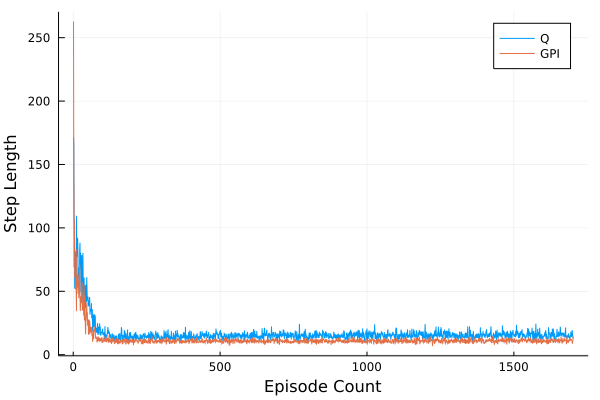

In [224]:
# episode_lengths = hcat([epi[1:max_length] for epi in episode_lengths_raw]...)
p = plot(xlabel = "Episode Count", ylabel = "Step Length")
for (ind,episode_lengths) in enumerate(episode_lengths_arr)
    l = hcat([epi[1:max_length] for epi in episode_lengths]...)
    plot!(p,mean(l,dims=2), label = blearners[ind])
end
# p = plot(mean(episode_lengths,dims=2), xlabel="Episode Count", ylabel="Step Length", hline=5.5)
display(p)
savefig("plots/experiment2/step_length.png")

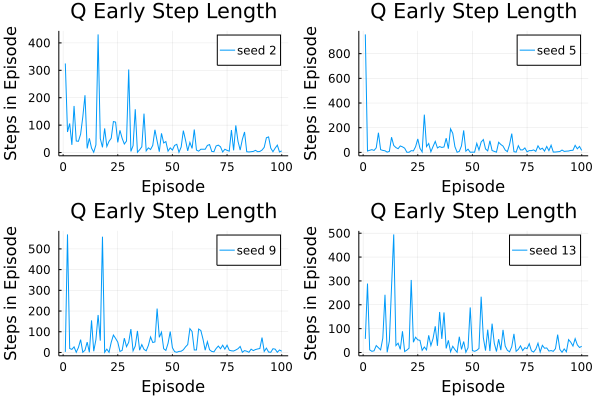

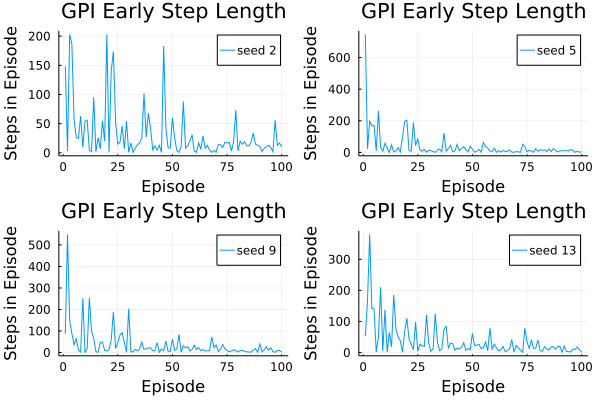

In [255]:
for (b_ind,ep_lengths) in enumerate(episode_lengths_arr)
    inds = [2,5,9,13]
    ps = []
    num_gvfs = 4
    for (i_i,i) in enumerate(inds)
        push!(ps, plot(ep_lengths[i][1:100], label = "seed $(inds[i_i])", xlabel="Episode", ylabel="Steps in Episode"))
    end
    full_p = plot(ps..., title = string(blearners[b_ind], " Early Step Length"))
    display(full_p)
    savefig("./plots/experiment2/step_length_samples_$(blearners[b_ind]).png")
end

In [193]:
function onehot(data, num_gvfs)
    onehot_enc = zeros(num_gvfs, length(data))
    for gvf_i in 1:num_gvfs
        onehot_enc[gvf_i,:] += (data .== gvf_i)
    end
    return onehot_enc
end

onehot (generic function with 1 method)

In [197]:
function get_goal_percentage(visits,m_length)
    num_gvfs = 4
    goal_visits = zeros(num_gvfs, m_length)
    for run in 1:length(visits)
        goal_visits += onehot(visits[run],num_gvfs)[:,1:m_length]
    end
    goal_visit_percentage = goal_visits / length(visits)
end

get_goal_percentage (generic function with 2 methods)

In [198]:
labels = ["Distractor" "Constant" "Drifter" "Constant"]

1×4 Array{String,2}:
 "Distractor"  "Constant"  "Drifter"  "Constant"

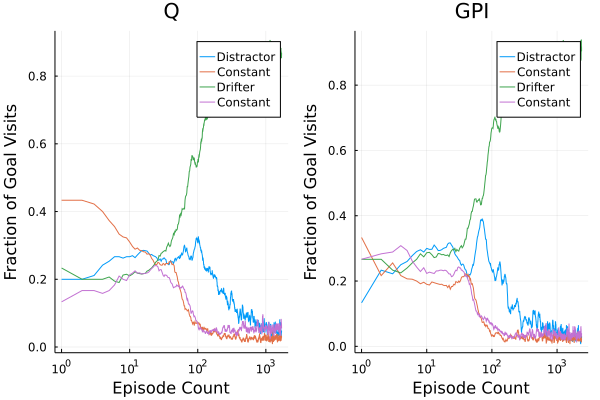

In [263]:
ps = []
for i in 1:length(ic_arr)
    visit_perc = get_goal_percentage(visits_arr[i], max_lengths[i])
#     @show size(GPU.smooth(visit_perc, 5))
    smooth_visit_perc = GPU.smooth(visit_perc, 5)
    tmp = [GPU.smooth(visit_perc[i,:],20) for i in 1:4] 
    p = plot(tmp, labels = labels, xlabel="Episode Count", ylabel="Fraction of Goal Visits", title = blearners[i], xaxis=:log)
    push!(ps,p)
end
plot(ps...)
display(plot(ps...))
savefig("plots/experiment2/goal_visitations.png")

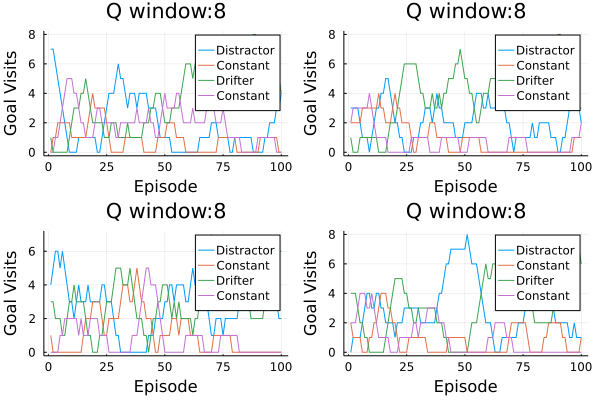

length(data) = 1771
length(data) = 1771
length(data) = 1771
length(data) = 1771
length(data) = 1744
length(data) = 1744
length(data) = 1744
length(data) = 1744
length(data) = 1806
length(data) = 1806
length(data) = 1806
length(data) = 1806
length(data) = 1785
length(data) = 1785
length(data) = 1785
length(data) = 1785


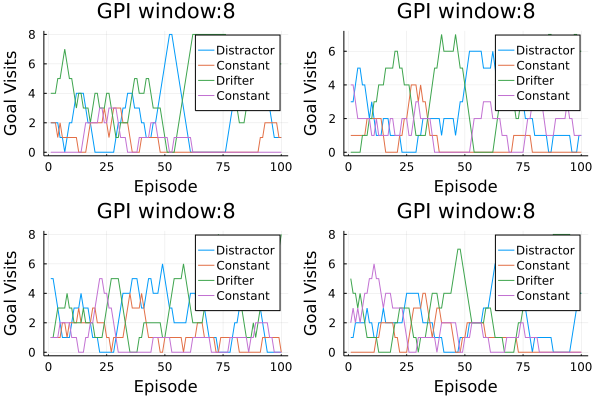

length(data) = 2476
length(data) = 2476
length(data) = 2476
length(data) = 2476
length(data) = 2563
length(data) = 2563
length(data) = 2563
length(data) = 2563
length(data) = 2529
length(data) = 2529
length(data) = 2529
length(data) = 2529
length(data) = 2499
length(data) = 2499
length(data) = 2499
length(data) = 2499


In [257]:
function mv_ave(data, window)
    @show length(data)
    return [sum(data[i:i+window-1]) for i in 1:(length(data) - window)]
end
temporal_cut_off = 100
window = 8
for (b_ind,visits) in enumerate(visits_arr)
    inds = [1,2,3,4]
    ps = []
    num_gvfs = 4
    for i in inds
        d = onehot(visits[i], num_gvfs)
        
        tmp = [mv_ave(d[gvf_i,:],window)[1:temporal_cut_off] for gvf_i in 1:num_gvfs]
        
        push!(ps, plot(tmp, labels = labels, xlabel="Episode", ylabel="Goal Visits"))
    end
    full_p = plot(ps..., title = string(blearners[b_ind], " window:", window))
    display(full_p)
    savefig("./plots/experiment2/temporal_coherence_$(blearners[b_ind]).png")
end

In [154]:
algo_divisor_keys = ["demon_learner", "demon_opt", "demon_update"]
# algo_divisor_keys = ["behaviour_eta"]
# algo_divisor_keys = []
sweep_params = ["demon_eta"]
sweep_params = ["demon_eta", "demon_beta_m", "demon_beta_v"]

algo_specs_full = GPU.split_algo(ic, algo_divisor_keys)
# algo_specs_full = ic

["demon_learner", "demon_opt", "demon_update"]


1-element Array{Dict{Any,Any},1}:
 Dict()

In [331]:
all_algos_ics = [search(ic,algo_spec) for algo_spec in algo_specs_full]
# all_algos_ics = [search(ic,algo_specs_full)]
length.(all_algos_ics)


12-element Array{Int64,1}:
   0
   0
   0
 100
 400
 400
 400
 400
   0
 400
   0
 400

In [332]:
valid_algos_ind = findall(a -> length(a) != 0, all_algos_ics)

algo_specs = algo_specs_full[valid_algos_ind]
algo_ics = all_algos_ics[valid_algos_ind]

7-element Array{ItemCollection,1}:
 ItemCollection(Reproduce.Item[Reproduce.Item("../Experiment1/data/RP_0_0x12d213e888552a8f", Dict{String,Any}("logger_keys" => ["TTMAZE_ERROR", "TTMAZE_UNIFORM_ERROR", "TTMAZE_OLD_ERROR"],"steps" => 2000,"behaviour_learner" => "Q","exploration_param" => 0.0,"exploration_strategy" => "epsilon_greedy","use_external_reward" => true,"demon_eta" => 0.25,"horde_type" => "regular","drifter" => [1.0, 0.1],"_GIT_INFO" => "0"…), ["logger_keys", "steps", "behaviour_learner", "exploration_param", "exploration_strategy", "use_external_reward", "demon_eta", "horde_type", "drifter", "demon_lambda"  …  "demon_alpha_init", "exploring_starts", "demon_beta_m", "demon_opt", "constant_target", "behaviour_alpha_init", "seed", "demon_discounts", "demon_policy_type", "intrinsic_reward"]), Reproduce.Item("../Experiment1/data/RP_0_0x139c6379aace4fb8", Dict{String,Any}("logger_keys" => ["TTMAZE_ERROR", "TTMAZE_UNIFORM_ERROR", "TTMAZE_OLD_ERROR"],"steps" => 2000,"behaviour_learn

In [333]:
algo_specs

7-element Array{Any,1}:
 Dict{Any,Any}("demon_learner" => "LSTD","demon_opt" => "Descent","demon_update" => "TB")
 Dict{Any,Any}("demon_learner" => "Q","demon_opt" => "Auto","demon_update" => "ESARSA")
 Dict{Any,Any}("demon_learner" => "Q","demon_opt" => "Auto","demon_update" => "TB")
 Dict{Any,Any}("demon_learner" => "Q","demon_opt" => "Descent","demon_update" => "ESARSA")
 Dict{Any,Any}("demon_learner" => "Q","demon_opt" => "Descent","demon_update" => "TB")
 Dict{Any,Any}("demon_learner" => "SR","demon_opt" => "Auto","demon_update" => "TB")
 Dict{Any,Any}("demon_learner" => "SR","demon_opt" => "Descent","demon_update" => "TB")

In [334]:
best_per_algo_ics = []
for (i,algo_ic) in enumerate(algo_ics)
    println(i)
    push!(best_per_algo_ics, GPU.get_best(algo_ic,sweep_params, data_key))
end

1
["demon_eta", "demon_beta_m", "demon_beta_v"]
[0.4430862783141038]
2
["demon_eta", "demon_beta_m", "demon_beta_v"]
[0.3740271733605441, 0.37192692427370583, 0.3687569449824799, 0.3809315504883154]
3
["demon_eta", "demon_beta_m", "demon_beta_v"]
[0.3143307918999292, 0.3130003497043294, 0.31087232185784136, 0.31208711487085483]
4
["demon_eta", "demon_beta_m", "demon_beta_v"]
[0.5342441642809787, 0.44007966361890094, 0.3782132404564028, 0.3985954085462324]
5
["demon_eta", "demon_beta_m", "demon_beta_v"]
[0.5814507465613101, 0.46617821210111604, 0.3827059712702012, 0.3375045789648443]
6
["demon_eta", "demon_beta_m", "demon_beta_v"]
[0.2708300386794722, 0.2530627732946938, 0.23944810934259728, 0.24973697746217247]
7
["demon_eta", "demon_beta_m", "demon_beta_v"]
[0.6925866239930669, 0.5386889996632931, 0.39237700643919393, 0.2996737809837711]


In [335]:
length.(best_per_algo_ics)

7-element Array{Int64,1}:
 100
 100
 100
 100
 100
 100
 100

In [455]:
data = [GPU.smooth(GPU.get_stats(GPU.load_results(ic,data_key))[1],5) for ic in best_per_algo_ics]
std = [GPU.smooth(GPU.get_stats(GPU.load_results(ic,data_key))[2],5) for ic in best_per_algo_ics]

size(GPU.load_results(best_per_algo_ics[1], data_key))
# GVF x timesteps x num_runs
# tst = GPU.load_results(best_per_algo_ics[1], data_key)
# size(tst)
# std(sum(tst,dims=1)[1,:,:], dims =2)
# methods(std)
# std(tst,dims=3)

(4, 40, 100)

In [456]:
algo_specs
[GPU.print_params(algo, algo_divisor_keys, sweep_params) for algo in best_per_algo_ics]

For IC: 
demon_learner  LSTD
demon_opt  Descent
demon_update  TB
demon_eta  0.25
demon_beta_m  0.9
demon_beta_v  0.99

For IC: 
demon_learner  Q
demon_opt  Auto
demon_update  ESARSA
demon_eta  0.3
demon_beta_m  0.9
demon_beta_v  0.99

For IC: 
demon_learner  Q
demon_opt  Auto
demon_update  TB
demon_eta  0.3
demon_beta_m  0.9
demon_beta_v  0.99

For IC: 
demon_learner  Q
demon_opt  Descent
demon_update  ESARSA
demon_eta  0.3
demon_beta_m  0.9
demon_beta_v  0.99

For IC: 
demon_learner  Q
demon_opt  Descent
demon_update  TB
demon_eta  1.0
demon_beta_m  0.9
demon_beta_v  0.99

For IC: 
demon_learner  SR
demon_opt  Auto
demon_update  TB
demon_eta  0.3
demon_beta_m  0.9
demon_beta_v  0.99

For IC: 
demon_learner  SR
demon_opt  Descent
demon_update  TB
demon_eta  1.0
demon_beta_m  0.9
demon_beta_v  0.99



7-element Array{Nothing,1}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

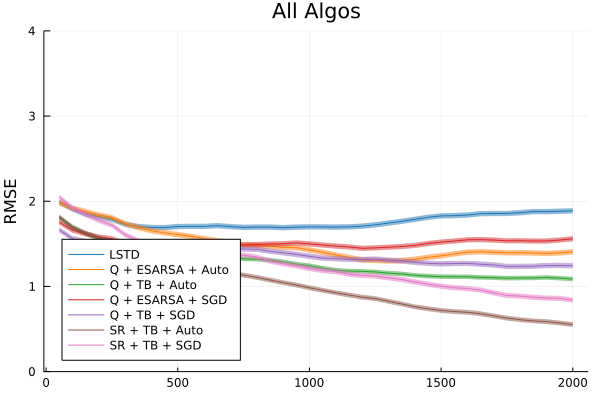

In [457]:
# labels = ["LSTD" "Q + ESARSA + Auto" "Q + ESARSA + SGD"]
# labels = ["LSTD" "Q + TB + ADAM" "Q + ESARSA + Auto" "Q + Auto + TB" "Q + ESARSA + SGD" "Q + TB + SGD" "SR + TB + ADAM" "SR + TB + Auto" "SR + TB + SGD"]
labels = ["LSTD" "Q + ESARSA + Auto" "Q + TB + Auto" "Q + ESARSA + SGD" "Q + TB + SGD" "SR + TB + Auto" "SR + TB + SGD"]
# labels = ["LSTD" "LSTD Different Seeds"]
ylabel = "RMSE"
title = "All Algos"
step_increment=50
num_samples = length(data[1])
xticks=collect(step_increment:step_increment:num_samples*step_increment)
(:tab10)
plot(xticks, data, ylabel=ylabel, palette=:tab10, label= labels, ylims=(0,4), grid=true, ribbon = std/sqrt(100), legend=:bottomleft, title=title)

In [458]:
savefig("./plots/experiment_1_correct_alpha_true_stderr.png")

In [459]:
#Replicating plot from Experiment 1.
# inds_to_replicate = [1,3,4,8]
inds_to_replicate = [1,2,3,6]
label_subset = labels[:,inds_to_replicate]
data_subset = data[inds_to_replicate]

label_subset

1×4 Array{String,2}:
 "LSTD"  "Q + ESARSA + Auto"  "Q + TB + Auto"  "SR + TB + Auto"

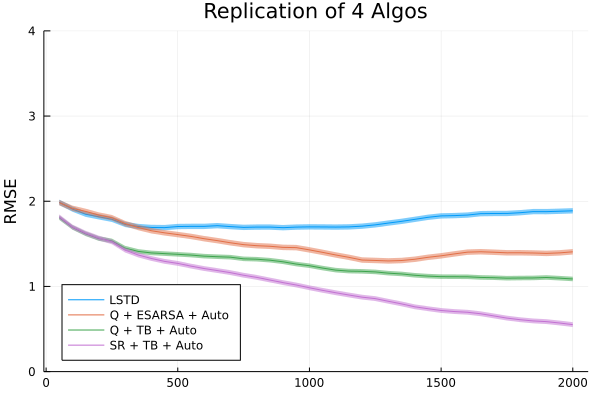

In [460]:
title = "Replication of 4 Algos"
ylabel = "RMSE"
step_increment=50
num_samples = length(data[1])
xticks=collect(step_increment:step_increment:num_samples*step_increment)
plot(xticks, data_subset,ylabel= ylabel, label= label_subset, ribbon = std[inds_to_replicate]/sqrt(100), legend=:bottomleft, title=title, ylims=(0,4))

In [461]:
savefig("./plots/experiment_1_4_algos_correct_alpha_true_stderr.png")

In [207]:
inds_to_replicate = [7,8, 9]
label_subset = labels[:,inds_to_replicate]
data_subset = data[inds_to_replicate]


3-element Array{Array{Float64,1},1}:
 [0.5470549290708173, 0.5212190400471071, 0.49216639285327873, 0.4653320115299161, 0.4477887139508697, 0.4084287460859707, 0.3785749953282733, 0.3592267467094625, 0.34759570453328126, 0.33820016563394917  …  0.28403781472182166, 0.2848598191169727, 0.28444952123342226, 0.2842364178862737, 0.2859633968533841, 0.2892072786470155, 0.29051251336091466, 0.2942060215997294, 0.2961037754226114, 0.2974369350200642]
 [0.4526388514975741, 0.42297273753498443, 0.40404919265022765, 0.3892259144652882, 0.3779355074214255, 0.3532320006190545, 0.3383446034608478, 0.327711325407632, 0.3192585699472274, 0.31331895288744754  …  0.17318704681602984, 0.17093016734965416, 0.1665747622843587, 0.16036576741892497, 0.1543744242800278, 0.14903807234072547, 0.14509537776409856, 0.14310018894930765, 0.1389905900762675, 0.13384219276484205]
 [0.5119967839355531, 0.4809337591693461, 0.4609934253354934, 0.443871124190541, 0.4300067608411817, 0.40170838286179544, 0.38401002434843

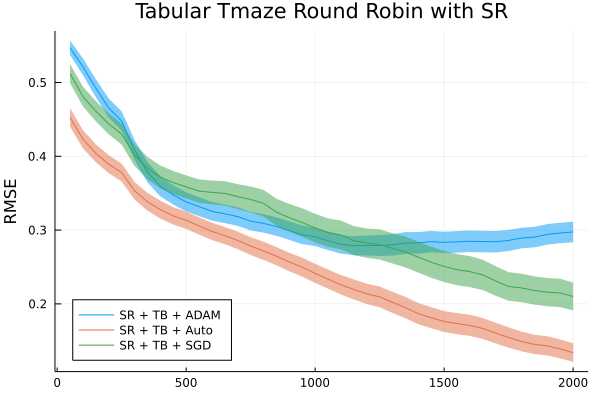

In [208]:
title = "Tabular Tmaze Round Robin with SR"
ylabel = "RMSE"
step_increment=50
num_samples = length(data[1])
xticks=collect(step_increment:step_increment:num_samples*step_increment)
plot(xticks, data_subset,ylabel= ylabel, label= label_subset, ribbon = std[inds_to_replicate]/sqrt(100), legend=:bottomleft, title=title)

In [209]:
savefig("./plots/TabTMazeRoundRobinSRVariants_old_weighting.png")

In [447]:
data_per_gvf = [GPU.get_stats(GPU.load_results(ic,data_key), per_gvf=true)[1] for ic in best_per_algo_ics]
std_per_gvf = [GPU.get_stats(GPU.load_results(ic,data_key), per_gvf=true)[2] for ic in best_per_algo_ics]

7-element Array{Array{Float64,2},1}:
 [0.0583830341159143 0.06624647800274217 … 0.025331506725205462 0.024397293962268633; 0.03889287145799879 0.03446226870970493 … 0.014794991119714154 0.01528194549588694; 0.3079138638493579 0.35845048085670994 … 0.9572012726441534 0.9556570344074108; 0.035480788145793404 0.031832843362199124 … 0.015620569934822087 0.01531906940544899]
 [0.05746913114522719 0.060282673279872516 … 0.06374158349618055 0.0663021718397726; 0.04238311595926881 0.04003501526891254 … 0.05524423798772834 0.05587831566970883; 0.3171130805123134 0.3811126732560389 … 0.5272433890472962 0.5564420792754703; 0.04308688359476702 0.04525075299928103 … 0.051676072712286886 0.0507582939644684]
 [0.08544790467545224 0.06717454621790661 … 0.08152217411938359 0.08263905464901689; 0.06831416291205408 0.04849036245726658 … 0.06357413347350213 0.06104375465736899; 0.27642337654811006 0.2944612366188357 … 0.44236477127168583 0.392611894224175; 0.05330815977525475 0.04235849230265052 … 0.06063

In [382]:
GPU.get_stats(GPU.load_results(best_per_algo_ics[1],data_key), per_gvf=true)[2]

4×40 Array{Float64,2}:
 0.058383   0.0662465  0.0679944  …  0.0257236  0.0253315  0.0243973
 0.0388929  0.0344623  0.0264279     0.0146811  0.014795   0.0152819
 0.307914   0.35845    0.380958      0.934579   0.957201   0.955657
 0.0354808  0.0318328  0.0251053     0.016249   0.0156206  0.0153191

In [420]:
data[1] .== data[3]

4×40 BitArray{2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

In [446]:
inds_to_replicate

4-element Array{Int64,1}:
 1
 2
 3
 6

In [451]:
ps = []
for ind in inds_to_replicate
    label_subset = labels[:,ind]
    data_subset = data_per_gvf[ind]
    std_subset = std_per_gvf[ind]
    @show size(std_subset)
    xticks=collect(step_increment:step_increment:num_samples*step_increment)
    p = plot(xticks,data_subset',label= ["Distractor" "Const" "Drifter" "Const"], ribbon = (std_subset/sqrt(100))', legend=:bottomleft, title=labels[ind], ylims=(0,1.25))
    push!(ps,p)
end

size(std_subset) = (4, 40)
size(std_subset) = (4, 40)
size(std_subset) = (4, 40)
size(std_subset) = (4, 40)


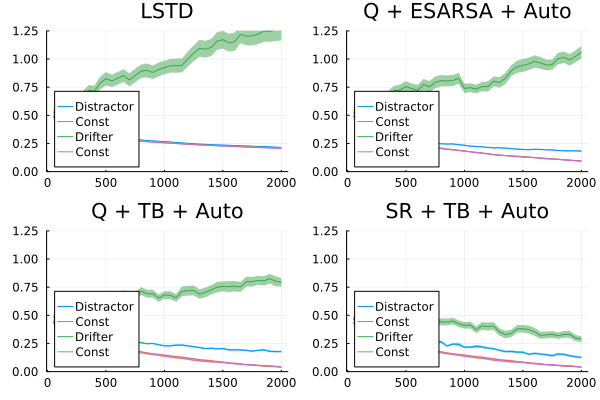

In [452]:
plot(ps..., layout=(2,2))

In [453]:
savefig("./plots/TabTMazeRoundRobin_per_gvf.png")